In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import skew, kurtosis

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls "/content/gdrive/MyDrive/creditfraud"

df_test_filled.csv	  dftrain_corr.csv     test_identity.csv     train_identity.csv     vif.csv
dftrain_corr_cleaned.csv  df_train_filled.csv  test_transaction.csv  train_transaction.csv


## Scope of the notebook: Detecting fraudulent transactions
In this notebook we are going to perform the whole process of data pre-processing, feature-engineering and model-finetuning for the following question from the competition page on Kaggle:

Can you detect fraud from customer transactions?

The data set contains of real-world e-commerce transactions with lots of nice features to experiment with. So let's get started!

See further details on [IEEE-CIS Fraud Detection](https://www.kaggle.com/competitions/ieee-fraud-detection)

# Loading the Data

In [ ]:
#Loading the competition data for credit fraud detection. Test and Trainsets were already given
#source of the dataset: https://www.kaggle.com/competitions/ieee-fraud-detection

#train set
dftrain_id = pd.read_csv("/content/gdrive/MyDrive/creditfraud/train_identity.csv")
dftrain_tr = pd.read_csv("/content/gdrive/MyDrive/creditfraud/train_transaction.csv")

#test set (I need this for validation)
dftest_id = pd.read_csv("/content/gdrive/MyDrive/creditfraud/test_identity.csv")
dftest_tr = pd.read_csv("/content/gdrive/MyDrive/creditfraud/test_transaction.csv")

In [ ]:
# Function to reduce memory usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
dftrain_id=reduce_mem_usage(dftrain_id)

Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%


In [ ]:
dftrain_tr=reduce_mem_usage(dftrain_tr)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


In [ ]:
dftest_id=reduce_mem_usage(dftest_id)

Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.84 MB
Decreased by 77.8%


In [ ]:
dftest_tr=reduce_mem_usage(dftest_tr)

Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%


In [ ]:
#analysing the shapes

In [ ]:
dftrain_id.shape

(144233, 41)

In [ ]:
dftrain_tr.shape

(590540, 394)

In [ ]:
dftest_id.shape

(141907, 41)

In [ ]:
dftest_tr.shape

(506691, 393)

In [ ]:
#From the competition page we know that the transaction dataset can be merged with the identity dataset by TransactionID. So let's do this here.
dftrain = pd.merge(dftrain_tr, dftrain_id, on='TransactionID', how='left')

In [ ]:
dftest = pd.merge(dftest_tr, dftest_id, on='TransactionID', how='left')

After the merge we have more columns in the dataframe df_train compared to dftrain_tr:

In [ ]:
dftrain.shape

(590540, 434)

In [ ]:
dftest.shape

(506691, 433)

# Missing Values

## Overview

Getting an idea about the data types and their missing values in the dataframe dftrain:

In [ ]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(354), float32(45), int16(1), int32(2), int8(1)
memory usage: 525.6 MB


In [ ]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(354), float32(45), int16(1), int32(2), int8(1)
memory usage: 525.6 MB


In [ ]:
def print_missing_data_by_column_type(df):
    """
    Prints the null value counts and percentages for each column, sorted by data type and then by
    Null Percentage descending.

    Args:
        df: The pandas DataFrame to analyze.
    """

    # Count null values and calculate percentages
    unique_with_counts = df.nunique()
    null_counts = df.isnull().sum()
    null_percentages = (null_counts / len(df)) * 100

    # Create a DataFrame with column names, data types, null counts, and percentages
    missing_data_df = pd.DataFrame({
        "Column Name": df.columns,
        "Data Type": df.dtypes,
        "Unique": unique_with_counts,
        "Null Count": null_counts,
        "Null Percentage": null_percentages.round(1)
    })

    # Convert 'Data Type' column to string type
    missing_data_df['Data Type'] = missing_data_df['Data Type'].astype(str)

    # Sort by Data Type and then by Null Percentage in descending order
    missing_data_df = missing_data_df.sort_values(by=['Data Type', 'Null Percentage'], ascending=[True, False])

    # Set display options to show all rows
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    # Print the resulting DataFrame
    print(missing_data_df)

In [ ]:
print_missing_data_by_column_type(dftrain)

                   Column Name Data Type  Unique  Null Count  Null Percentage
id_23                    id_23  category       3      585371             99.1
id_27                    id_27  category       2      585371             99.1
id_33                    id_33  category     260      517251             87.6
id_30                    id_30  category      75      512975             86.9
id_34                    id_34  category       4      512735             86.8
DeviceInfo          DeviceInfo  category    1786      471874             79.9
id_16                    id_16  category       2      461200             78.1
R_emaildomain    R_emaildomain  category      60      453249             76.8
id_31                    id_31  category     130      450258             76.2
DeviceType          DeviceType  category       2      449730             76.2
id_15                    id_15  category       3      449555             76.1
id_28                    id_28  category       2      449562    

In [ ]:
#check again how many rows there are in the dataframe
dftrain.shape

(590540, 434)

In [ ]:
# Count rows with missing data
missing_rows_count = dftrain.isnull().any(axis=1).sum()
print(f"The number of rows with missing data is: {missing_rows_count}")

The number of rows with missing data is: 590540


We can conclude that all rows in the data contain missing values. In the next row we can see the distribution of missing rows grouped by the target variable isFraud.

In [ ]:
# Count rows with missing values by is Fraud
missing_mask = dftrain.isnull().any(axis=1)
print(missing_mask.value_counts())
print(" ")
print(dftrain.loc[missing_mask, 'isFraud'].value_counts())
print(" ")
print(round(dftrain.loc[missing_mask, 'isFraud'].value_counts(normalize = True), 2))

True    590540
Name: count, dtype: int64
 
isFraud
0    569877
1     20663
Name: count, dtype: int64
 
isFraud
0    0.97
1    0.03
Name: proportion, dtype: float64


We can compare the distribution of missing values also with the distribution of all rows by isFraud:

In [ ]:
# Target distribution
print(dftrain['isFraud'].value_counts())
print(" ")
print(round(dftrain['isFraud'].value_counts(normalize = True), 2))

isFraud
0    569877
1     20663
Name: count, dtype: int64
 
isFraud
0    0.97
1    0.03
Name: proportion, dtype: float64


We can conclude that the amount of missing rows is the same as the total count of rows by isFraud. We can therefore not see any difference pattern in here. Therefore we may drop data with more than >=70% of missing data.

## Dropping Duplicates
Before we are going to drop missing value columns we will drop duplicate values.

In [ ]:
#Remove duplicates for training data
dftrain = dftrain.copy()
dftrain.drop_duplicates(inplace=True)

In [ ]:
dftrain.shape

(590540, 434)

In [ ]:
#Remove duplicates for test data
dftest = dftest.copy()
dftest.drop_duplicates(inplace=True)

NameError: name 'dftest' is not defined

In [ ]:
dftest.shape

## Dropping columns with >=70% missing values

In [ ]:
def drop_null_cols(df):
    null_counts = df.isnull().sum()
    null_percentages = (null_counts / len(df)) * 100

    # Create a new DataFrame to store null information
    null_info_df = pd.DataFrame({'Column Name': null_counts.index,
                                  'Null Count': null_counts.values,
                                  'Null Percentage': null_percentages.values})

    columns_to_drop = null_info_df[null_info_df['Null Percentage'] >= 70]['Column Name'].tolist()

    # Print the columns to be dropped
    if columns_to_drop:
        print("Dropping columns with null percentage >= 70%:")
        for col in columns_to_drop:
            print(f"- {col}")

    # Drop the identified columns
    df = df.drop(columns_to_drop, axis=1)

    return df

In [ ]:
dftrain_dropped = drop_null_cols(dftrain)

Dropping columns with null percentage >= 70%:
- dist2
- R_emaildomain
- D6
- D7
- D8
- D9
- D12
- D13
- D14
- V138
- V139
- V140
- V141
- V142
- V143
- V144
- V145
- V146
- V147
- V148
- V149
- V150
- V151
- V152
- V153
- V154
- V155
- V156
- V157
- V158
- V159
- V160
- V161
- V162
- V163
- V164
- V165
- V166
- V167
- V168
- V169
- V170
- V171
- V172
- V173
- V174
- V175
- V176
- V177
- V178
- V179
- V180
- V181
- V182
- V183
- V184
- V185
- V186
- V187
- V188
- V189
- V190
- V191
- V192
- V193
- V194
- V195
- V196
- V197
- V198
- V199
- V200
- V201
- V202
- V203
- V204
- V205
- V206
- V207
- V208
- V209
- V210
- V211
- V212
- V213
- V214
- V215
- V216
- V217
- V218
- V219
- V220
- V221
- V222
- V223
- V224
- V225
- V226
- V227
- V228
- V229
- V230
- V231
- V232
- V233
- V234
- V235
- V236
- V237
- V238
- V239
- V240
- V241
- V242
- V243
- V244
- V245
- V246
- V247
- V248
- V249
- V250
- V251
- V252
- V253
- V254
- V255
- V256
- V257
- V258
- V259
- V260
- V261
- V262
- V263
- V264
- V

In [ ]:
dftrain.shape

(590540, 434)

In [ ]:
dftrain_dropped.shape

(590540, 226)

In [ ]:
#check current dftrain_dropped columns
print(", ".join(dftrain_dropped.columns.tolist()))

TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, P_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D10, D11, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, V55, V56, V57, V58, V59, V60, V61, V62, V63, V64, V65, V66, V67, V68, V69, V70, V71, V72, V73, V74, V75, V76, V77, V78, V79, V80, V81, V82, V83, V84, V85, V86, V87, V88, V89, V90, V91, V92, V93, V94, V95, V96, V97, V98, V99, V100, V101, V102, V103, V104, V105, V106, V107, V108, V109, V110, V111, V112, V113, V114, V115, V116, V117, V118, V119, V120, V121, V122, V123, V124, V125, V126, V127, V128, V129, V130, V131, V132, V133, V134, V135, V136, V137, V279, V280

In [ ]:
#check current dftest columns
print(", ".join(dftest.columns.tolist()))

NameError: name 'dftest' is not defined

We can see from the analysis that the dftest columns starting with id-* differ from the ones in dftrain_dropped, which are id_*. Therefore, we are going toreplace the id- with id_ prefix.

In [ ]:
#Renameing ids in dftest
def rename_id_columns(df):
  for col in df.columns:
    if col.startswith('id-'):
      new_col_name = col.replace('id-', 'id_')
      df = df.rename(columns={col: new_col_name})
  return df

#Apply the function to the DataFrame
dftest = rename_id_columns(dftest)

In [ ]:
print(", ".join(dftest.columns.tolist()))

TransactionID, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, V55, V56, V57, V58, V59, V60, V61, V62, V63, V64, V65, V66, V67, V68, V69, V70, V71, V72, V73, V74, V75, V76, V77, V78, V79, V80, V81, V82, V83, V84, V85, V86, V87, V88, V89, V90, V91, V92, V93, V94, V95, V96, V97, V98, V99, V100, V101, V102, V103, V104, V105, V106, V107, V108, V109, V110, V111, V112, V113, V114, V115, V116, V117, V118, V119, V120, V121, V122, V123, V124, V125, V126, V127, V128, V129, V130, V131, V1

No we can drop the same columns in dftest which we already dropped for the dftrain_dropped dataframe.

In [ ]:
# List of columns to drop
columns_to_drop = ['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']

# drop columns
dftest_dropped = dftest.drop(columns_to_drop, axis=1)

In [ ]:
dftest.shape

(506691, 433)

In [ ]:
dftest_dropped.shape

(506691, 359)

Missing Value Strategies for numerical columns:

*   Median: weightage on central tendency robust to outliers
*   Mean: weightage on central tendency sensitive to outliers
*   constant: 0 with no weightage on a tendency
*   constant: -999 with weightage on outliers
*   k-nearest: for continious data
*   iterative imputer: regression imputation sensitive to outliers

We have lots of columns with lots of missing data. Since the aim of the model is to find anomalies in the data it is useful to take a strategy that does not bias the data toward a certain tendency. Since the data is not continious k-nearest is also not the best option. Therefore the missing value strategy is chosen to fill nulls with the constant 0 in order to better find anomalies. It also has the advantage that it does not affect variables that might have already been scaled. We are also not dropping columns with missing values since these could be an indicator for fraudulent actions.

In [ ]:
#In a prediction context, simple imputation usually performs poorly when associated with a weak learner. However, with a powerful learner, it can lead to as good or better performance than complex imputation such as IterativeImputer or KNNImputer.

## Filling missing values

In [ ]:
#Filtering numerics
numerics = dftrain_dropped.select_dtypes(include=np.number)
print(numerics.shape)

#Filtering category columns in a list
categories = dftrain_dropped.select_dtypes(exclude=np.number)
print(categories.shape)

(590540, 213)
(590540, 13)


In [ ]:
impute_zeros = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
dftrain_numerics = pd.DataFrame(impute_zeros.fit_transform(numerics), columns=numerics.columns)
del numerics
print(dftrain_numerics.shape)

(590540, 213)


In [ ]:
impute_missing = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')
dftrain_categories = pd.DataFrame(impute_missing.fit_transform(categories), columns=categories.columns)
del categories
print(dftrain_categories.shape)

(590540, 13)


In [ ]:
# Concatinating numerics and categories
dftrain_combined = pd.concat([dftrain_categories, dftrain_numerics], axis=1)
del dftrain
print(dftrain_combined.shape)

(590540, 226)


In [ ]:
dftrain_combined=reduce_mem_usage(dftrain_combined)

Memory usage of dataframe is 1018.23 MB
Memory usage after optimization is: 269.77 MB
Decreased by 73.5%


In [ ]:
#check if null values are eliminated
print_missing_data_by_column_type(dftrain_combined)

                   Column Name Data Type  Unique  Null Count  Null Percentage
TransactionID    TransactionID   float64  590540           0              0.0
isFraud                isFraud   float64       2           0              0.0
TransactionDT    TransactionDT   float64  573349           0              0.0
TransactionAmt  TransactionAmt   float64    8195           0              0.0
card1                    card1   float64   13553           0              0.0
card2                    card2   float64     501           0              0.0
card3                    card3   float64     115           0              0.0
card5                    card5   float64     120           0              0.0
addr1                    addr1   float64     333           0              0.0
addr2                    addr2   float64      75           0              0.0
dist1                    dist1   float64    2412           0              0.0
C1                          C1   float64    1495           0    

In [ ]:
#Remove the combined dataframe
del dftrain_combined

# Analysing numerics

We are going to analyse the numerical columns in boxplots first.

In [ ]:
#Get the columns of numerics
dftrain_num_cols=dftrain_numerics.columns

# Define the number of columns per row for subplots
num_cols = 5

# Calculate the number of rows for subplots
num_plots = len(dftrain_num_cols)
num_rows = int(np.ceil(num_plots / num_cols))

# Create subplots for box plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate and plot box plots
for i, column in enumerate(dftrain_num_cols):
  sns.boxplot(ax=axes[i], x=dftrain_numerics[column])
  axes[i].set_title(f'Univariate Box Plot for {column}')
  axes[i].set_xlabel(column)

# Hide any unused subplots
for i in range(num_plots, num_rows * num_cols):
  axes[i].set_visible(False)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

We can see from the data that most of the features have lots of outliers and are therefore very likely skewed, meaning they dont follow a normal distribution. In order to get an idea about the skewness we are going to analyse it in the following.

We are going to drop the target and keep the remaining numerics.

In [ ]:
dftrain_nums = dftrain_numerics.drop(['isFraud'], axis=1)

In [ ]:
#make all rows and columns visible in the output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

After dropping the target we are having a look on the stats and skewness.

In [ ]:
#Getting overall stats for numerics
print(dftrain_nums.describe())

       TransactionID  TransactionDT  TransactionAmt          card1  \
count   5.905400e+05   5.905400e+05   590540.000000  590540.000000   
mean    3.282270e+06   7.372311e+06      135.027347    9898.734658   
std     1.704744e+05   4.617224e+06      239.157438    4901.170153   
min     2.987000e+06   8.640000e+04        0.250977    1000.000000   
25%     3.134635e+06   3.027058e+06       43.312500    6019.000000   
50%     3.282270e+06   7.306528e+06       68.750000    9678.000000   
75%     3.429904e+06   1.124662e+07      125.000000   14184.000000   
max     3.577539e+06   1.581113e+07    31936.000000   18396.000000   

               card2          card3          card5          addr1  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean      357.071172     152.788941     197.841689     258.385512   
std       162.727883      13.791462      44.420452     132.506081   
min         0.000000       0.000000       0.000000       0.000000   
25%       204.000000    

In [ ]:
#Getting skewness
skewed_features = dftrain_nums.skew().abs().sort_values(ascending=False)

In [ ]:
print(skewed_features)

V311              3.239159e+02
V129              2.404122e+02
V309              2.249508e+02
V319              1.818355e+02
V135              1.449214e+02
V321              1.235577e+02
V305              9.605166e+01
V137              9.060692e+01
V131              8.965186e+01
C3                8.894975e+01
V312              7.363357e+01
V320              7.051626e+01
V292              5.122856e+01
V291              5.015874e+01
V68               5.007554e+01
V136              4.903493e+01
V28               4.595142e+01
V27               4.346809e+01
V89               4.188610e+01
V290              3.457051e+01
V107              3.236957e+01
V101              3.063932e+01
V293              3.058265e+01
V95               3.025019e+01
V132              3.023951e+01
V279              3.023881e+01
V316              3.009770e+01
V126              2.958954e+01
V306              2.927317e+01
C12               2.741519e+01
C7                2.719403e+01
V102              2.699743e+01
V133    

As we can see from the stats that most of the data is positively skewed and contains outliers. Since we want to keep the outliers to detect fraudulent action we are choosing the robust scaler that is outlier resilient.

# Feature Encoding

We are going to analyse the categories by checking their histograms.

In [ ]:
#Getting categorical columns
dftrain_cat_cols=dftrain_categories.columns

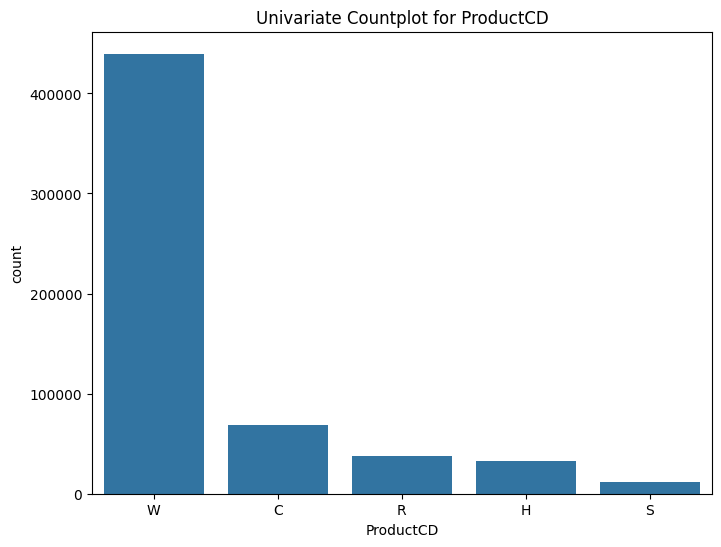

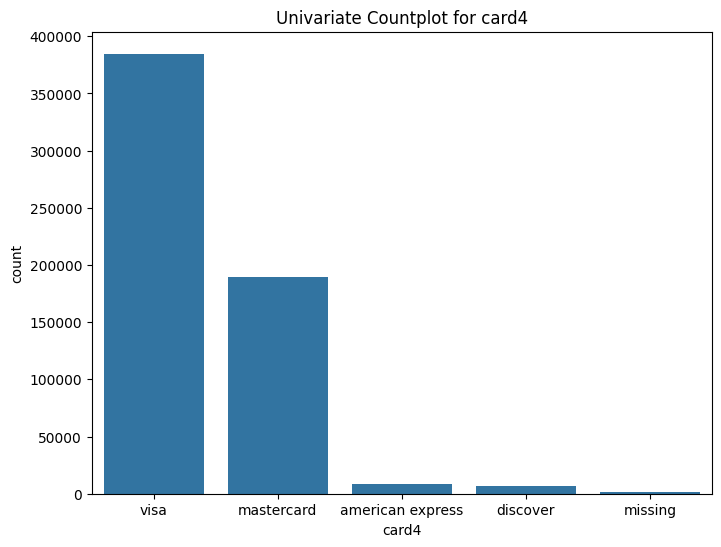

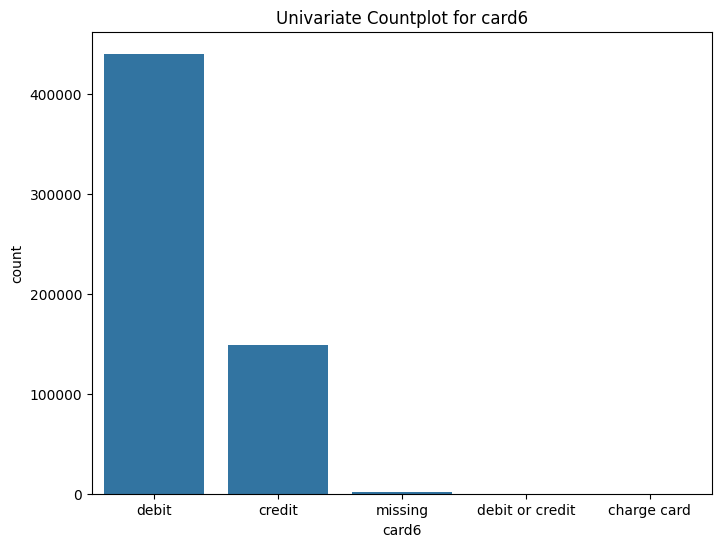

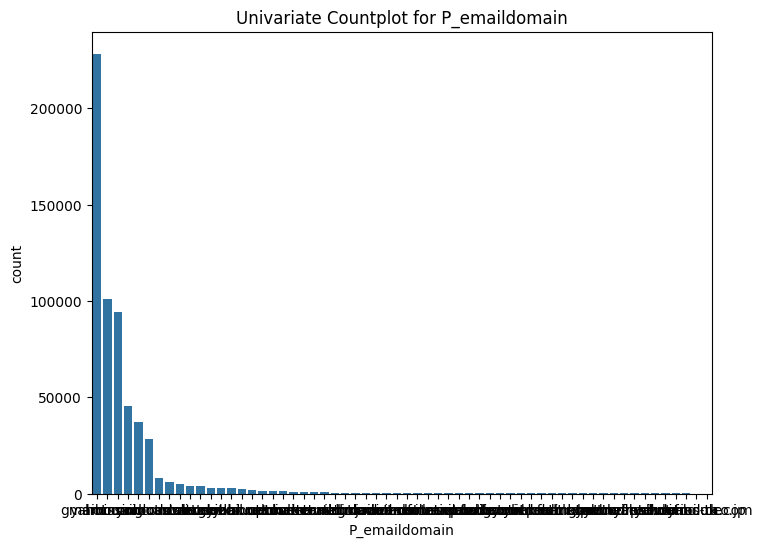

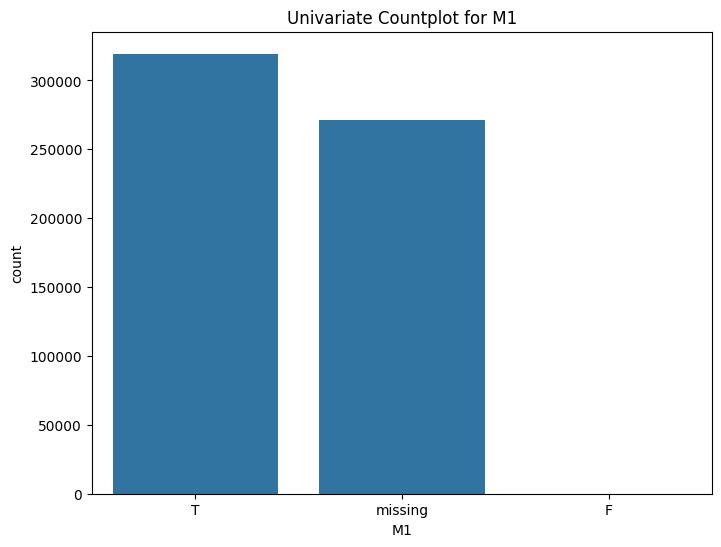

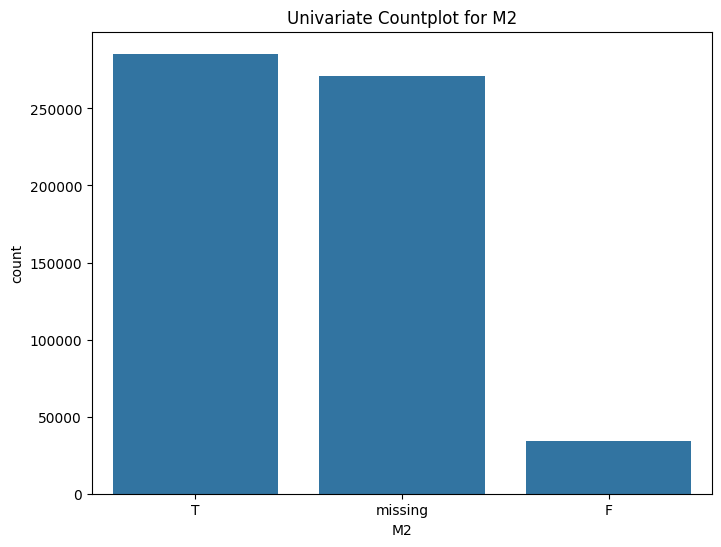

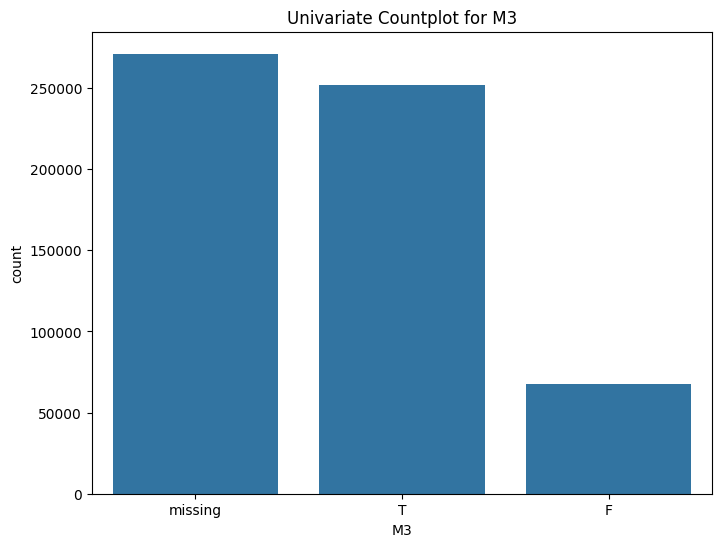

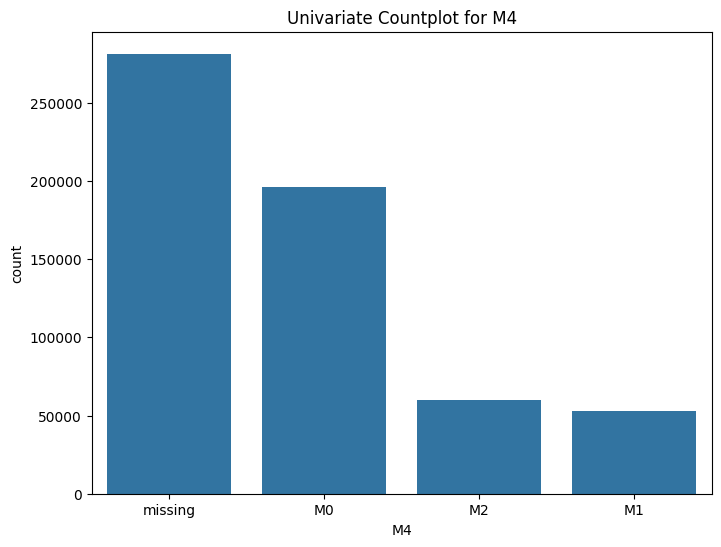

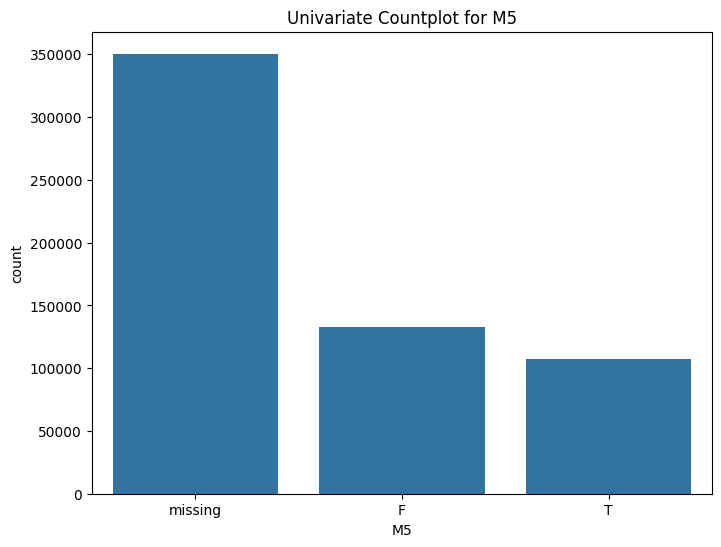

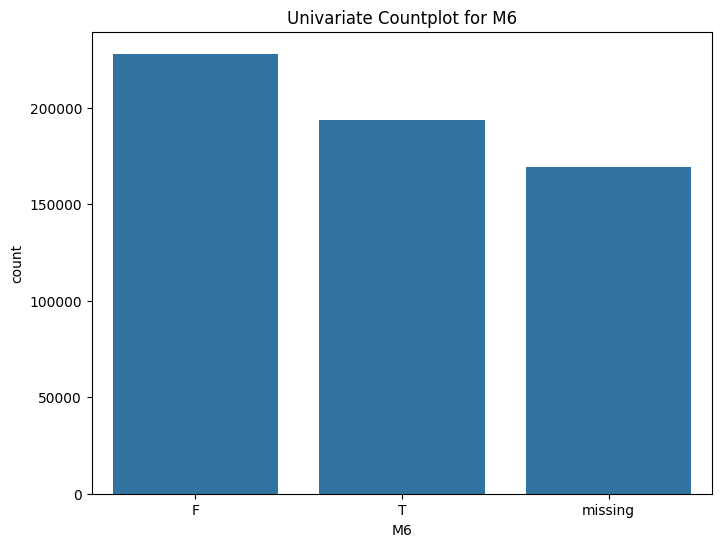

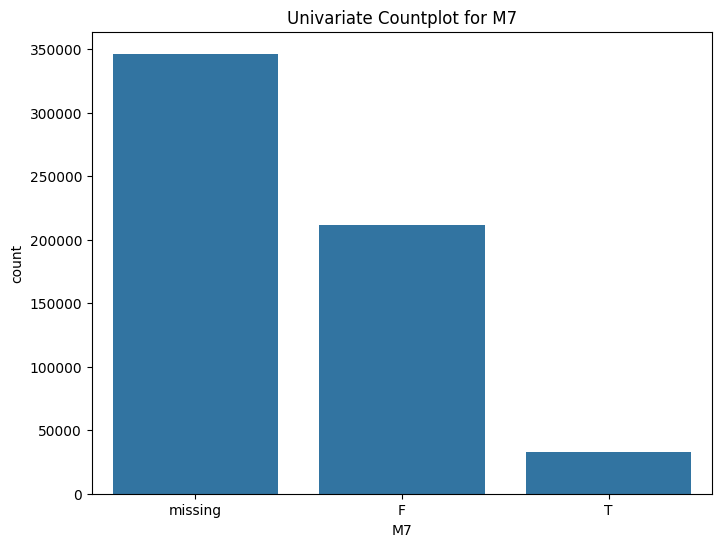

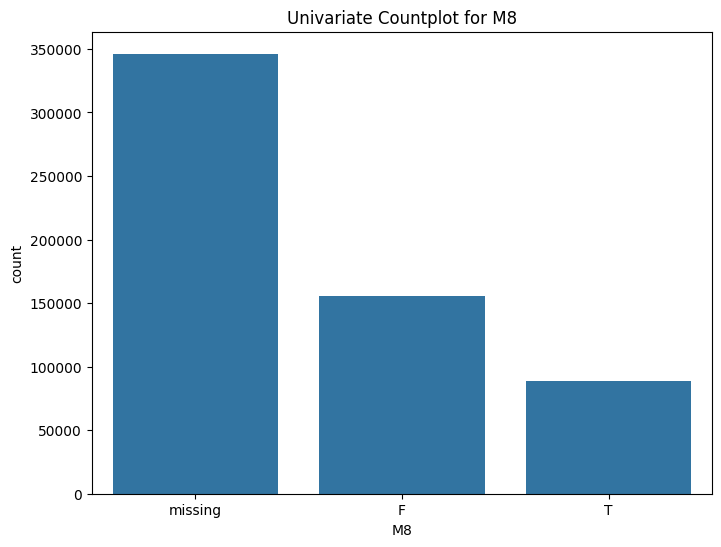

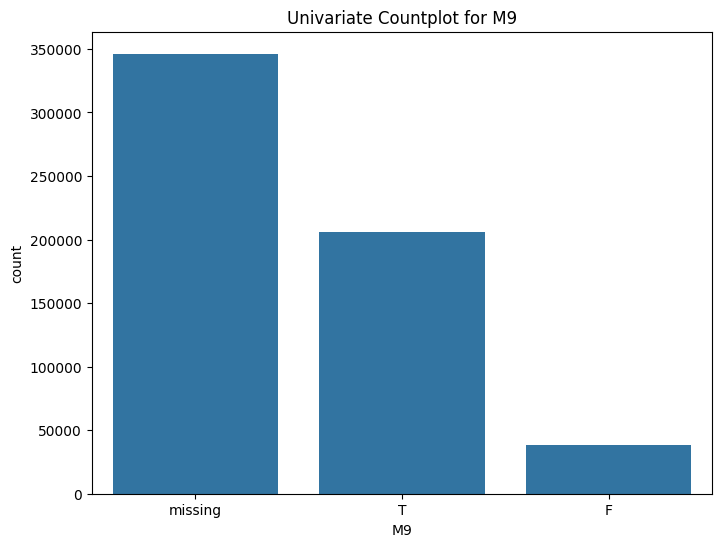

In [ ]:
#Getting histograms for categories
for column in dftrain_cat_cols:
  plt.figure(figsize=(8, 6))
  sns.countplot(x=dftrain_categories[column], order = dftrain_categories[column].value_counts().index)
  plt.title(f'Univariate Countplot for {column}')
  plt.show()

We can apply one-hot encoding directly on all categories except for P_emaildomain. This contains too many categories. Therefore we are squeezing the rare ones together.  

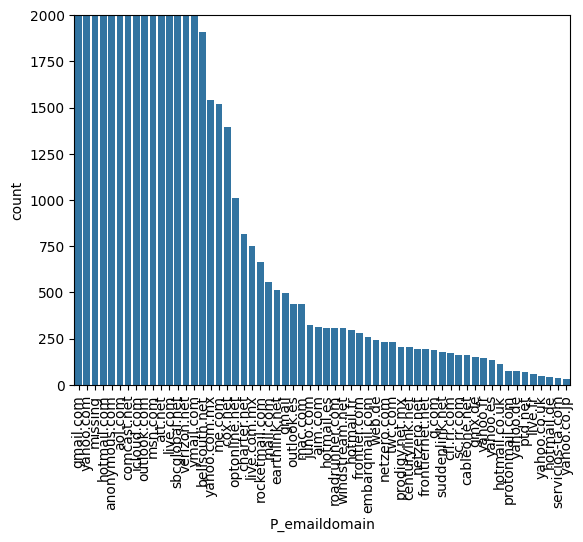

In [ ]:
#Make a copy of the data frame
dftrain_email = dftrain_categories.copy()

#Visualize the email domains
sns.countplot(x = 'P_emaildomain', data = dftrain_email, order = dftrain_email['P_emaildomain'].value_counts().index)
plt.xticks(rotation = 90)
plt.ylim(0, 2000)  # Set the y-axis limit
plt.show()
#Store the frequency(count) of each domain
frequency = dftrain_email['P_emaildomain'].value_counts()

In [ ]:
# Find domains with frequency less than the threshold
infrequent_domains = frequency[frequency < 1500].index

# Replace infrequent domains with 'Rare_Domain'
dftrain_email['P_emaildomain'] = dftrain_email['P_emaildomain'].replace(infrequent_domains, 'rare_domains')

#Check the unique Car Brands now
dftrain_email['P_emaildomain'].nunique()

19

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'gmail.com'),
  Text(1, 0, 'yahoo.com'),
  Text(2, 0, 'missing'),
  Text(3, 0, 'hotmail.com'),
  Text(4, 0, 'anonymous.com'),
  Text(5, 0, 'aol.com'),
  Text(6, 0, 'rare_domains'),
  Text(7, 0, 'comcast.net'),
  Text(8, 0, 'icloud.com'),
  Text(9, 0, 'outlook.com'),
  Text(10, 0, 'msn.com'),
  Text(11, 0, 'att.net'),
  Text(12, 0, 'live.com'),
  Text(13, 0, 'sbcglobal.net'),
  Text(14, 0, 'verizon.net'),
  Text(15, 0, 'ymail.com'),
  Text(16, 0, 'bellsouth.net'),
  Text(17, 0, 'yahoo.com.mx'),
  Text(18, 0, 'me.com')])

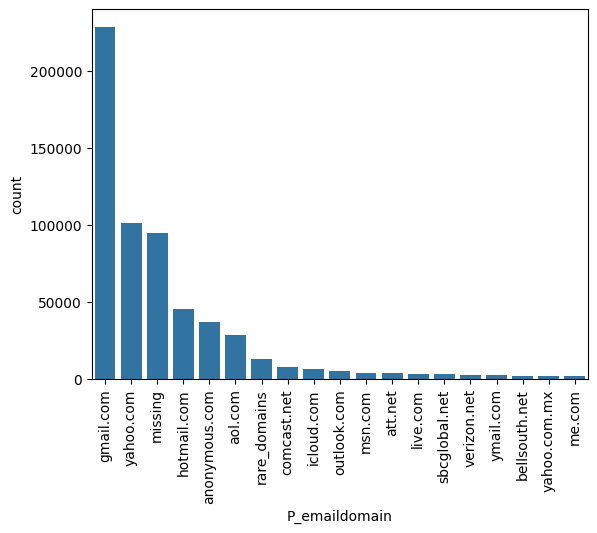

In [ ]:
sns.countplot(x = 'P_emaildomain', data = dftrain_email, order = dftrain_email['P_emaildomain'].value_counts().index)
plt.xticks(rotation = 90)

In [ ]:
#now let's perform one-hot encoding:
dftrain_email_encoded = pd.get_dummies(dftrain_email, columns=dftrain_cat_cols, drop_first=True)
dftrain_email_encoded = dftrain_email_encoded.astype(np.int8)
print(dftrain_email_encoded.head())

   ProductCD_H  ProductCD_R  ProductCD_S  ProductCD_W  card4_discover  card4_mastercard  \
0            0            0            0            1               1                 0   
1            0            0            0            1               0                 1   
2            0            0            0            1               0                 0   
3            0            0            0            1               0                 1   
4            1            0            0            0               0                 1   

   card4_missing  card4_visa  card6_credit  card6_debit  card6_debit or credit  card6_missing  \
0              0           0             1            0                      0              0   
1              0           0             1            0                      0              0   
2              0           1             0            1                      0              0   
3              0           0             0            1          

# Mutlicollinearity


In [ ]:
# Concatinating numerics and categories
dftrain_cleaned = pd.concat([dftrain_email_encoded, dftrain_numerics], axis=1)
del dftrain_email_encoded
del dftrain_email
del dftrain_categories
del dftrain_numerics
del frequency
del infrequent_domains
print(dftrain_cleaned.shape)

(590540, 262)


In [ ]:
#Drop the target for analysing multicollinearity
dftrain_corr=dftrain_cleaned.drop(['isFraud'], axis = 1)

In [ ]:
dftrain_corr.shape

(590540, 261)

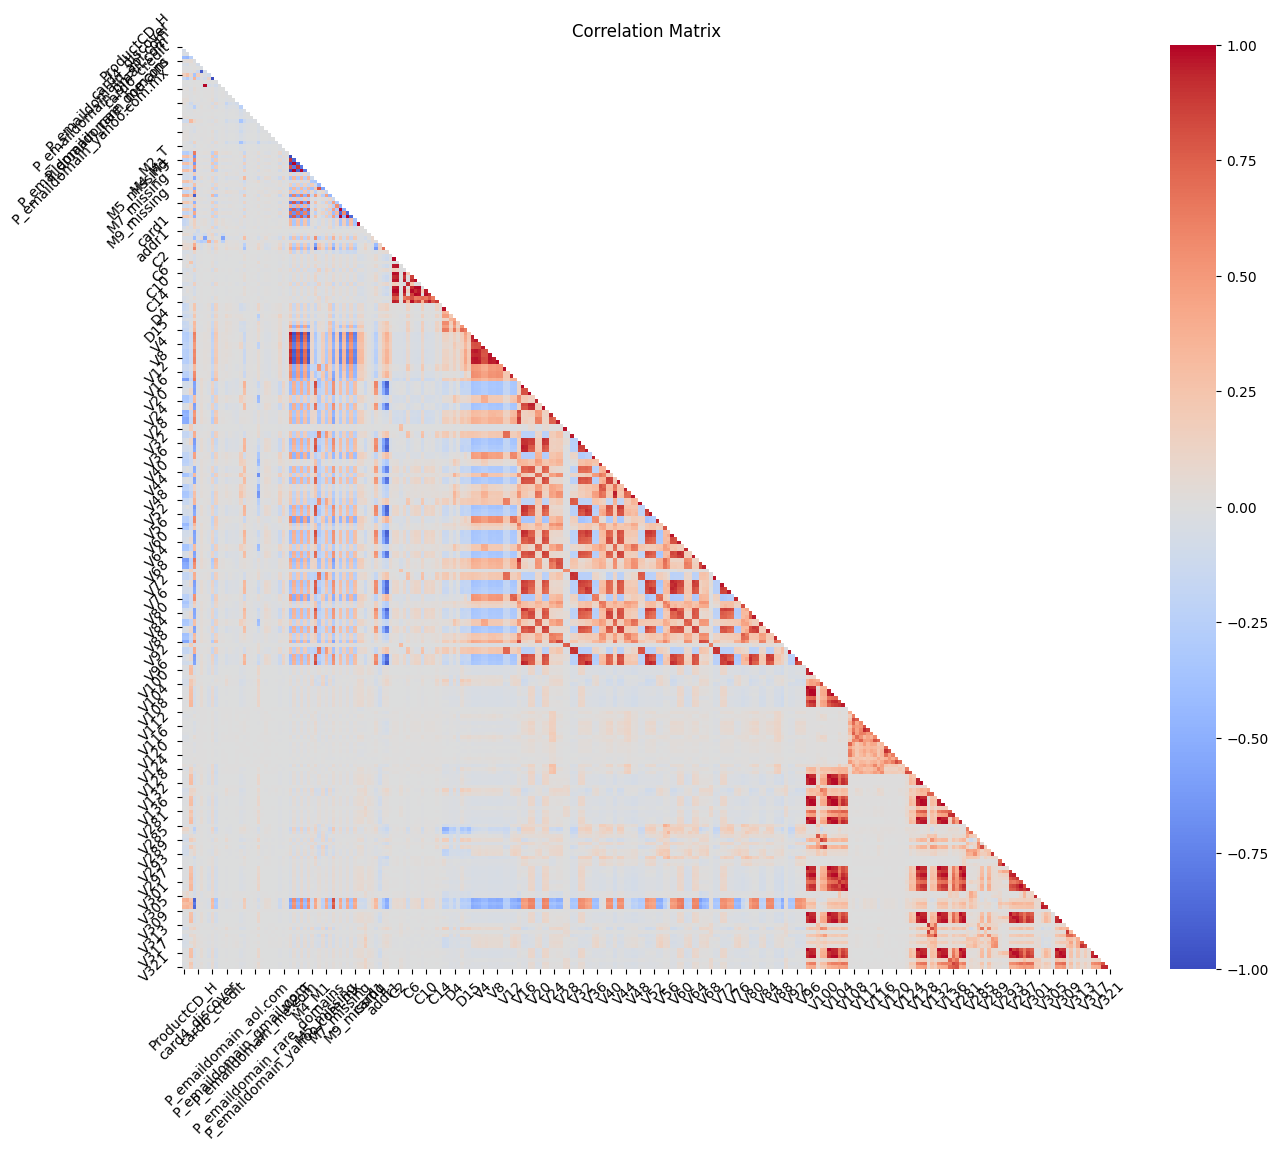

In [ ]:
# Calculate the correlation matrix
corr_matrix = dftrain_corr.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the plot
plt.figure(figsize=(15, 12))

# Plot the heatmap
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, annot=False)

# Customize the plot (optional)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
#Function to find highly correlated features among each other with a correlation coefficient >=0.9
def correlated_feature_pairs(df):
    correlated_pairs = []
    corr_matrix = df.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= 0.9:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                correlated_pairs.append((feature1, feature2))

    return correlated_pairs

correlated_pairs = correlated_feature_pairs(dftrain_corr)

print("Total",len(correlated_pairs),"correlated pairs found.")
print(" ")

for pair in correlated_pairs:
    print(f"Correlated Pair: {pair[0]} and {pair[1]}")

Total 471 correlated pairs found.
 
Correlated Pair: card4_visa and card4_mastercard
Correlated Pair: card6_debit and card6_credit
Correlated Pair: card6_missing and card4_missing
Correlated Pair: M1_missing and M1_T
Correlated Pair: M2_missing and M1_T
Correlated Pair: M2_missing and M1_missing
Correlated Pair: M3_missing and M1_T
Correlated Pair: M3_missing and M1_missing
Correlated Pair: M3_missing and M2_missing
Correlated Pair: M6_missing and ProductCD_W
Correlated Pair: M8_missing and M7_missing
Correlated Pair: M9_missing and M7_missing
Correlated Pair: M9_missing and M8_missing
Correlated Pair: TransactionDT and TransactionID
Correlated Pair: C2 and C1
Correlated Pair: C4 and C1
Correlated Pair: C4 and C2
Correlated Pair: C6 and C1
Correlated Pair: C6 and C2
Correlated Pair: C6 and C4
Correlated Pair: C7 and C1
Correlated Pair: C7 and C2
Correlated Pair: C8 and C1
Correlated Pair: C8 and C2
Correlated Pair: C8 and C4
Correlated Pair: C8 and C6
Correlated Pair: C8 and C7
Correla

In [ ]:
#With the following function we can select highly correlated features
#and later remove the first feature that is correlated with any other feature (pairwise correlation)

def correlation_detection(df):
    col_corr = set()  # Set of all the names of correlated columns
    correlated_pairs = []
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >=0.9:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
#Make a copy of the original data
dftrain_corr_features = dftrain_corr.copy()

In [ ]:
correlated_features = correlation_detection(dftrain_corr_features)
len(set(correlated_features))

120

In [ ]:
correlated_features

{'C10',
 'C11',
 'C12',
 'C14',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C9',
 'D2',
 'M1_missing',
 'M2_missing',
 'M3_missing',
 'M6_missing',
 'M8_missing',
 'M9_missing',
 'TransactionDT',
 'V1',
 'V101',
 'V102',
 'V103',
 'V105',
 'V106',
 'V11',
 'V113',
 'V119',
 'V126',
 'V127',
 'V128',
 'V13',
 'V132',
 'V133',
 'V134',
 'V137',
 'V15',
 'V16',
 'V18',
 'V2',
 'V20',
 'V21',
 'V22',
 'V24',
 'V26',
 'V279',
 'V28',
 'V280',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V301',
 'V304',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V315',
 'V316',
 'V317',
 'V318',
 'V32',
 'V321',
 'V33',
 'V34',
 'V36',
 'V38',
 'V40',
 'V43',
 'V45',
 'V46',
 'V47',
 'V49',
 'V5',
 'V50',
 'V51',
 'V52',
 'V54',
 'V57',
 'V58',
 'V6',
 'V60',
 'V62',
 'V63',
 'V64',
 'V65',
 'V67',
 'V69',
 'V7',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V76',
 'V79',
 'V8',
 'V81',
 'V83',
 'V84',
 'V85',
 'V87',
 'V9',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V96',


In [ ]:
#Drop the highly correlated features
dftrain_corr.drop(correlated_features, axis = 1, inplace = True)

In [ ]:
dftrain_corr.shape

(590540, 141)

In [ ]:
#Make another copy of the original data
dftrain_vif = dftrain_corr.copy()

In [ ]:
#Computing the VIF values
vif = pd.DataFrame()
vif["Feature"] = dftrain_vif.columns
vif["VIF"] = [variance_inflation_factor(dftrain_vif.values, i) for i in range(len(dftrain_vif.columns))]

# Display VIF values
print("VIF Values:")
print(vif.sort_values(by = 'VIF', ascending = False))

VIF Values:
                         Feature          VIF
106                         V117  3018.458725
97                          V107  2773.063170
133                         V305  2576.867964
108                         V120  2501.585104
110                         V122  1810.554340
..                           ...          ...
25    P_emaildomain_yahoo.com.mx     1.073134
26       P_emaildomain_ymail.com     1.071628
11   P_emaildomain_bellsouth.net     1.054706
17          P_emaildomain_me.com     1.042947
8          card6_debit or credit     1.001032

[141 rows x 2 columns]


In [ ]:
# Get a list of features to drop based on VIF > 10
features_to_drop = vif[vif['VIF'] > 10]['Feature'].tolist()

In [ ]:
# Drop the identified features from dftrain_corr
dftrain_corr_cleaned = dftrain_corr.drop(features_to_drop, axis=1)

In [ ]:
dftrain_corr_cleaned.shape

(590540, 73)

In [ ]:
#Save the cleaned data as CSV so it can be used further
dftrain_corr_cleaned.to_csv('/content/gdrive/MyDrive/creditfraud/dftrain_cleaned.csv', index=False)

# Splitting the data

First we are recalling the dataframe from the multicollinearity section.

In [ ]:
dftrain_corr_cleaned = pd.read_csv("/content/gdrive/MyDrive/creditfraud/dftrain_corr_cleaned.csv")

In [ ]:
dftrain_corr_cleaned=reduce_mem_usage(dftrain_corr_cleaned)

Memory usage of dataframe is 328.90 MB
Memory usage after optimization is: 65.33 MB
Decreased by 80.1%


In [ ]:
dftrain_corr_cleaned.shape

(590540, 73)

In [ ]:
#Generating a list of columns that we want to keep including the target 'isfraud'
corr_list = list(dftrain_corr_cleaned.columns)
corr_list.append('isFraud')

For multicollinearity we had to drop the target column but for the splitting we need the target again. This is why we drop for the features from dftrain_cleaned that are not contained in the list of corr_list.

In [ ]:
#Dropping columns that are not contained in corr_list
columns_to_drop = [col for col in dftrain_cleaned.columns if col not in corr_list]
dftrain_cleaned = dftrain_cleaned.drop(columns_to_drop, axis=1)

Note that the shape of dftrain_cleaned contains now 74 columns, while dftrain_corr_cleaned containes only 73 columns. This is due to the fact that we are including the target 'isfraud' for training split.

In [ ]:
dftrain_cleaned.shape

(590540, 74)

In [ ]:
#Save the cleaned data as CSV so it can be used further
#dftrain_cleaned.to_csv('/content/gdrive/MyDrive/creditfraud/dftrain_cleaned_ready_for_splitting.csv', index=False)

Now, let us continue with the actual splitting of the data.

In [ ]:
#Loading the data from the previous step
dftrain_cleaned = pd.read_csv("/content/gdrive/MyDrive/creditfraud/dftrain_cleaned_ready_for_splitting.csv")

In [ ]:
dftrain_cleaned=reduce_mem_usage(dftrain_cleaned)

Memory usage of dataframe is 333.40 MB
Memory usage after optimization is: 66.46 MB
Decreased by 80.1%


In [ ]:
#Defining the target y and dependent variables for training
X = dftrain_cleaned.drop('isFraud', axis=1)
y = dftrain_cleaned['isFraud']

In [ ]:
#Splitting the data into training and validation by using stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

In [ ]:
#Splitting the data into training and validation without cross validation
#X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42, shuffle=True)

# Scaling

In [ ]:
#Scaling the training data set
scaler=RobustScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)

# Model Training with Light GBM
Gradient Boosting Machines like XGBoost and LightGBM are popular algorithms for imbalanced datasets such as fraud detection, see
[for instance explained here](https://www.linkedin.com/pulse/why-gradient-boosting-machines-gbm-effective-fraud-detection-kalia-ybfqc#:~:text=Gradient%20Boosting%20Machines%2C%20particularly%20implementations,while%20offering%20high%20predictive%20accuracy.) This is why we are going to start from there by applying the Light GBM model.


In [ ]:
!pip install lightgbm scikit-learn

In [ ]:
import lightgbm as lgb
import time

from lightgbm import LGBMClassifier
from sklearn.metrics import class_likelihood_ratios, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, cohen_kappa_score, confusion_matrix, roc_curve, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV

In [ ]:
#Setting Light GBM parameters ==>changing parameters does not improve the model, I definitely need oversampling
params_lgb = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'num_leaves': 32,
    'num_iterations': 100,
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'lambda_l1': 0.1,
    'lambda_l2': 0,
    'importance_type': 'split',
    'is_unbalance': True
}

#Define the model
model_lgb = lgb.LGBMRegressor(**params_lgb)
#Train the model
model_lgb.fit(X_train, y_train)
#Predict y based on X_val, and convert predictions to binary using a threshold (e.g., 0.5)
y_pred = (model_lgb.predict(X_val) > 0.5).astype(int)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4555
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
[LightGBM] [Warning] No further sp

Accuracy = 0.8162275205743895
ROC Area under Curve = 0.7954197945723004
Precision  = 0.13333611551623403
Recall  = 0.7730462134043068
F1 Score  = 0.22744260544580885
Cohen's Kappa = 0.17840035919428465
Time taken = 0.7562596797943115
              precision    recall  f1-score   support

         0.0    0.99004   0.81779   0.89571    113975
         1.0    0.13334   0.77305   0.22744      4133

    accuracy                        0.81623    118108
   macro avg    0.56169   0.79542   0.56158    118108
weighted avg    0.96006   0.81623   0.87232    118108



Text(0.5, 0.98, 'Confusion Matrix')

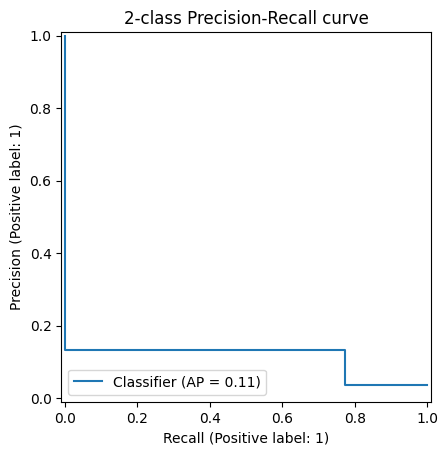

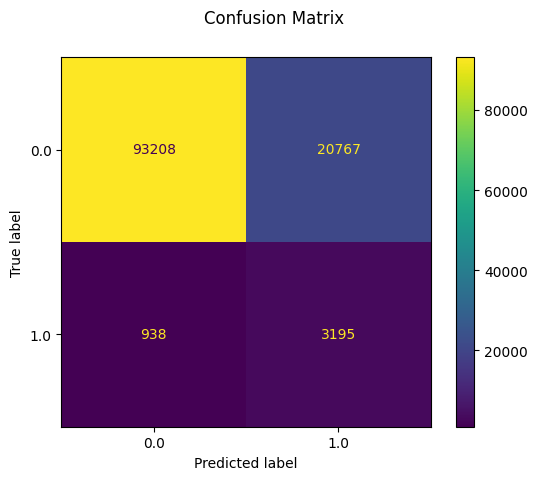

In [ ]:
#Getting the metrics
t0=time.time()
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
coh_kap = cohen_kappa_score(y_val, y_pred)
time_taken = time.time()-t0
print("Accuracy = {}".format(accuracy))
print("ROC Area under Curve = {}".format(roc_auc))
print("Precision  = {}".format(precision))
print("Recall  = {}".format(recall))
print("F1 Score  = {}".format(f1))
print("Cohen's Kappa = {}".format(coh_kap))
print("Time taken = {}".format(time_taken))
print(classification_report(y_val,y_pred,digits=5))
disp1 = PrecisionRecallDisplay.from_predictions(y_val, y_pred)
disp1.ax_.set_title("2-class Precision-Recall curve")
#comparing the predicted values y_pred to the actual y_val from the validation dataset
disp2 = ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
disp2.figure_.suptitle("Confusion Matrix")
#Fazit: dieses Modell ist wirklich schlecht

The model does moderatly well with an accuracy of approximetly 81%. This is highly due to the fact, that precision (around 13%) and recall (about 77%) for the fraudulent class are not as high as for the class without frauds. This is very likely due to the following reasons:

*   still too many features, making it hard for the model to predict frauds
*   class imbalance is too high, making predictions inaccurate for the minority class

This is why feature engineering should definetly further improved by addressing these issues.


